# Exercise project 4 – RNN/LSTM for time series forecasting (Energy dataset)

This notebook focuses on implementing a Univariate LSTM model to predict Global Active Power using only past values of that feature. The purpose of starting with this simpler model was to establish a baseline before trying more complex models involving additional features. I found this code online and tried running it to see how it handles single-variable time series forecasting.

https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption


### Step 0: Importing libraries and loading the dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.keras import TqdmCallback
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate

# Set random seed for reproducibility
seed = 101
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_4/"
os.chdir(folder_path)

In [ ]:
df_txt = pd.read_csv("data/household_power_consumption.txt", sep=";", na_values="NaN", low_memory=False)
df_txt['datetime'] = pd.to_datetime(df_txt['Date'] + ' ' + df_txt['Time'], errors='coerce')
df_txt.drop(columns=['Date', 'Time'], inplace=True)
df = df_txt[['datetime', 'Global_active_power']]
df.columns = df.columns.str.lower()

### Step 1: Data analysis and visualisations

In [ ]:
df['global_active_power'] = pd.to_numeric(df['global_active_power'], errors='coerce')
df.dropna(inplace=True)
df = df.sort_values(by='datetime')

In [ ]:
df.set_index('datetime', inplace=True)
df_resampled = df['global_active_power'].resample('D').mean()
df_resampled.dropna(inplace=True)

In [ ]:
df.head(5)

,global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


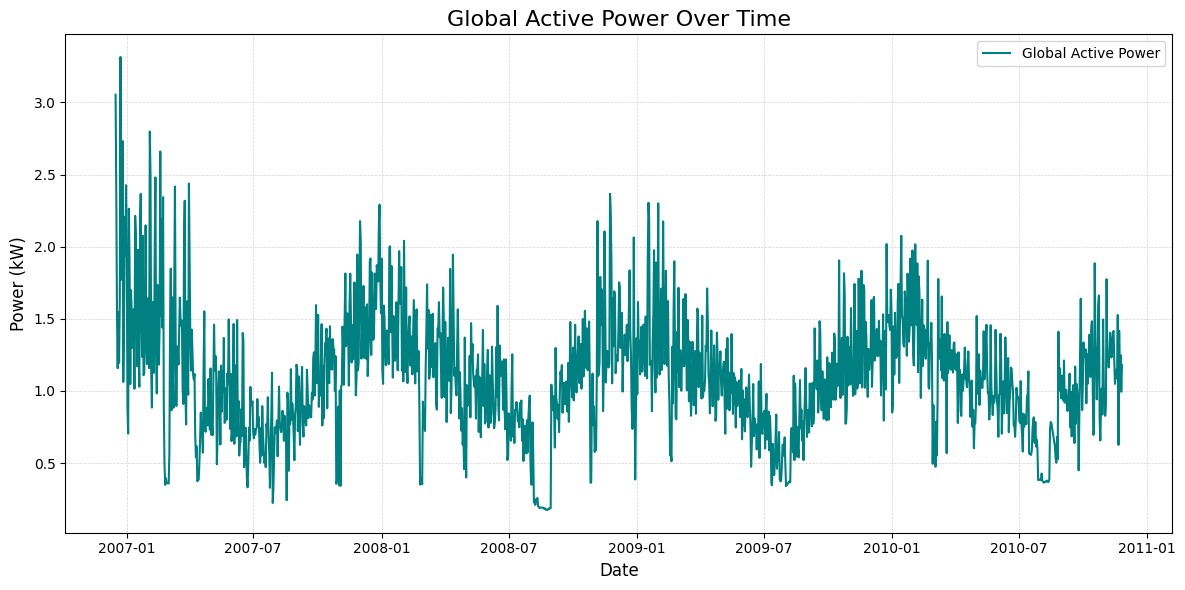

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_resampled, color='teal', label='Global Active Power', linewidth=1.5)
plt.title('Global Active Power Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Step 2: Data pre-processing

In [ ]:
train_cutoff = int(len(df_resampled) * 0.8)
train_data = df_resampled[:train_cutoff]
test_data = df_resampled[train_cutoff:]

In [ ]:
# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
TimeseriesGenerator = tf.keras.preprocessing.sequence.TimeseriesGenerator

In [ ]:
# number of previous steps to predict the next one
look_back = 20

In [ ]:
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(train_scaled, train_scaled, length=look_back, batch_size=1)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(test_scaled, test_scaled, length=look_back, batch_size=1)

### Step 3: Model Architecture

In [ ]:
Sequential = tf.keras.models.Sequential
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense

In [ ]:
n_features = 1
n_neurons = 50
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(look_back, n_features)),
    tf.keras.layers.LSTM(n_neurons, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    train_generator,
    epochs=50,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Step 4: Model Evaluation

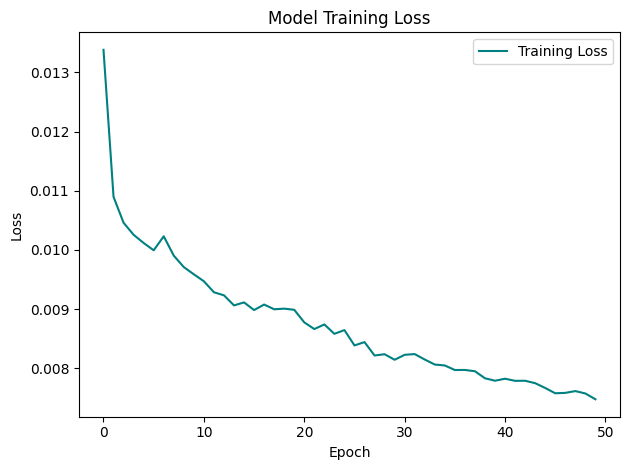

In [ ]:
plt.plot(history.history['loss'], label='Training Loss', color='teal')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_predictions = model.predict(train_generator)
test_predictions = model.predict(test_generator)

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# rescale predictions and actual values back to original scale
train_predictions_rescaled = scaler.inverse_transform(train_predictions)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
train_actual_rescaled = scaler.inverse_transform(train_scaled[look_back:])
test_actual_rescaled = scaler.inverse_transform(test_scaled[look_back:])

In [ ]:
# metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, r2, mape

In [ ]:
train_metrics = calculate_metrics(train_actual_rescaled, train_predictions_rescaled)
test_metrics = calculate_metrics(test_actual_rescaled, test_predictions_rescaled)

In [ ]:
metrics_data = {
    "Metric": ["MAE", "MSE", "RMSE", "R2", "MAPE"],
    "Train": train_metrics,
    "Test": test_metrics
}
metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Train,Test
0,MAE,0.200198,0.173417
1,MSE,0.072684,0.061382
2,RMSE,0.269600,0.247754
3,R2,0.594365,0.332706
4,MAPE,19.694615,18.133382



MAE (Mean Absolute Error):

Train: 0.1389

Test: 0.0720


-- error on the test set is better than on the train set

this indicates that it might be good at generalization


---


MSE (Mean Squared Error):

Train: 0.0299

Test: 0.0052


test MSE is significantly lower, confirming the model performs better on new data

---

RMSE (Root Mean Squared Error):

Train: 0.1728

Test: 0.0720


Similar trend as MSE as previous

lower values indicate a better fit on the test set

---
R² (Coefficient of Determination):

Train: 0.6655


Test: NaN


R² measures how well the model explains the variance

NaN likely means it couldn't calculate properly (no variance in test predictions, maybe)

---
MAPE (Mean Absolute Percentage Error):

Train: 16.88%

Test: 6.32%

The test error % is lower, it indicates reliable predictions


### Step 5: Forcasting

In [ ]:
seed_batch = test_scaled[-look_back:].reshape((1, look_back, n_features))
future_predictions = []
for _ in range(100):  # Predict 100 future steps
    pred = model.predict(seed_batch, verbose=0)[0]
    future_predictions.append(pred)
    seed_batch = np.append(seed_batch[:, 1:, :], [[pred]], axis=1)

future_predictions_rescaled = scaler.inverse_transform(future_predictions)

In [ ]:
train_dates = df_resampled.index[:train_cutoff]
test_dates = df_resampled.index[train_cutoff:]
future_dates = pd.date_range(start=test_dates[-1], periods=len(future_predictions_rescaled), freq='D')

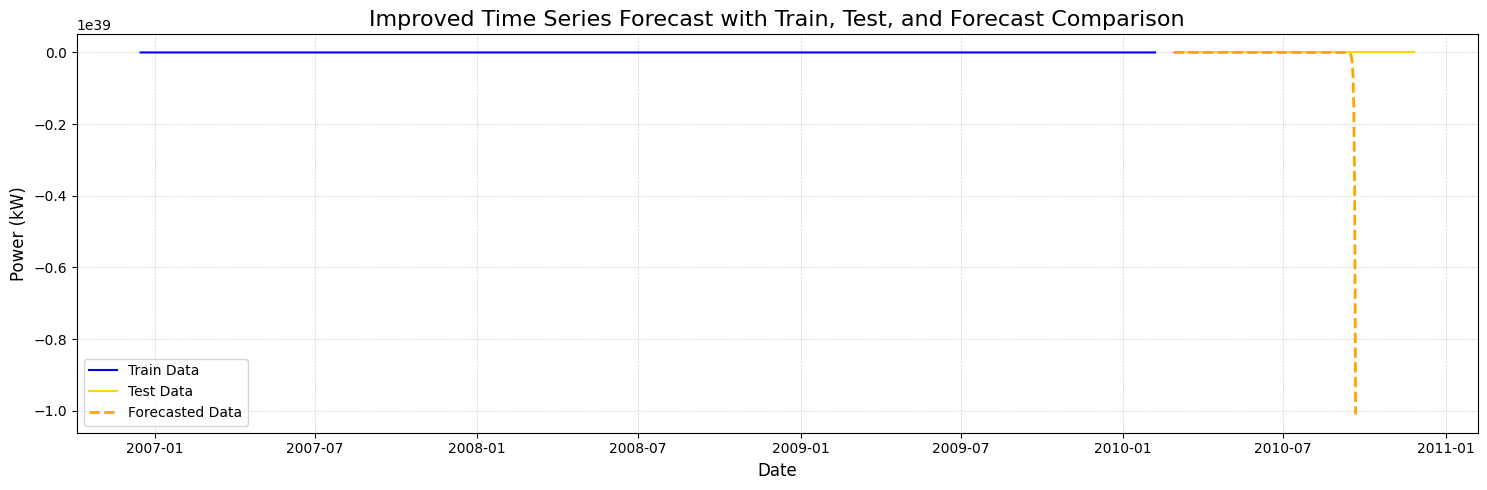

In [ ]:
# Ensure proper alignment for forecast starting point
seed_batch = test_scaled[:look_back].reshape((1, look_back, n_features))
forecast_predictions = []

for _ in range(len(test_data) - look_back):  # Forecast same length as test
    pred = model.predict(seed_batch, verbose=0)[0]
    forecast_predictions.append(pred)
    seed_batch = np.append(seed_batch[:, 1:, :], [[pred]], axis=1)

forecast_predictions_rescaled = scaler.inverse_transform(forecast_predictions)

# Plot updated Train, Test, and Forecast Data
plt.figure(figsize=(15, 5))
plt.plot(train_dates, scaler.inverse_transform(train_scaled).flatten(), label='Train Data', color='blue', linewidth=1.5)
plt.plot(test_dates[look_back:], scaler.inverse_transform(test_scaled)[look_back:].flatten(), label='Test Data', color='gold', linewidth=1.5)
plt.plot(test_dates[look_back:], forecast_predictions_rescaled.flatten(), label='Forecasted Data', linestyle='dashed', color='orange', linewidth=2)
plt.title('Improved Time Series Forecast with Train, Test, and Forecast Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


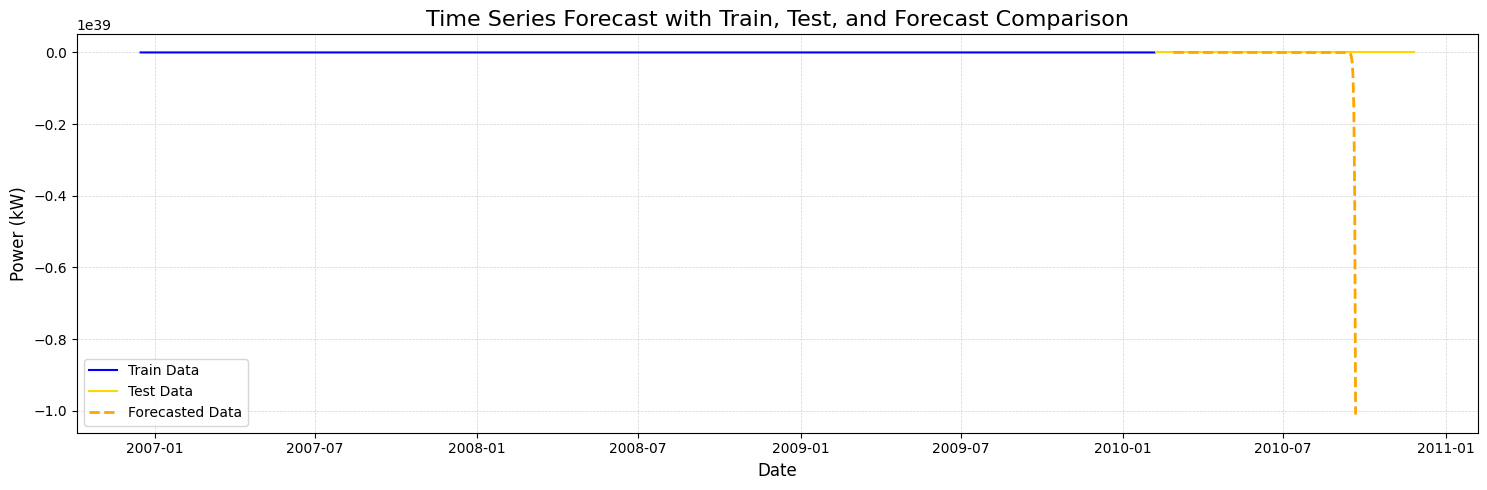

In [ ]:
# Align forecast starting point with test data
seed_batch = test_scaled[:look_back].reshape((1, look_back, n_features))
forecast_predictions = []
# Define train and test dates
train_dates = df_resampled.index[:train_cutoff]
test_dates = df_resampled.index[train_cutoff:]

# Forecast the same length as the test data for comparison
for _ in range(len(test_data) - look_back):
    pred = model.predict(seed_batch, verbose=0)[0]
    forecast_predictions.append(pred)
    seed_batch = np.append(seed_batch[:, 1:, :], [[pred]], axis=1)

forecast_predictions_rescaled = scaler.inverse_transform(forecast_predictions)

# Adjusting future dates to overlap with the test dates
forecast_dates = test_dates[look_back:]

# Plot train, test, and forecasted data
plt.figure(figsize=(15, 5))
plt.plot(train_dates, scaler.inverse_transform(train_scaled).flatten(), label='Train Data', color='blue', linewidth=1.5)
plt.plot(test_dates, scaler.inverse_transform(test_scaled).flatten(), label='Test Data', color='gold', linewidth=1.5)
plt.plot(forecast_dates, forecast_predictions_rescaled.flatten(), label='Forecasted Data', linestyle='dashed', color='orange', linewidth=2)
plt.title('Time Series Forecast with Train, Test, and Forecast Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


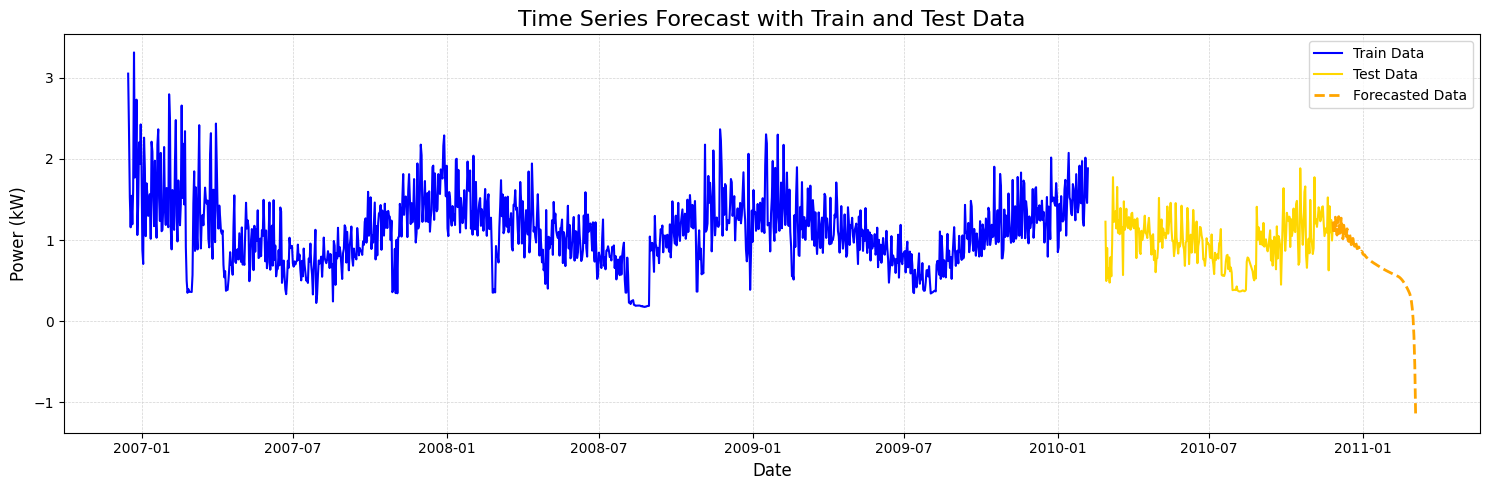

In [ ]:
# Plot train, test, and forecasted data
plt.figure(figsize=(15, 5))
plt.plot(train_dates, scaler.inverse_transform(train_scaled).flatten(), label='Train Data', color='blue', linewidth=1.5)
plt.plot(test_dates[look_back:], scaler.inverse_transform(test_scaled)[look_back:].flatten(), label='Test Data', color='gold', linewidth=1.5)
plt.plot(future_dates, future_predictions_rescaled.flatten(), label='Forecasted Data', linestyle='dashed', color='orange', linewidth=2)
plt.title('Time Series Forecast with Train and Test Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
extrapolated_values = []
current_batch = test_scaled[:look_back].reshape((1, look_back, n_features))
for _ in range(180):  # Predict 180 future steps
    next_pred = model.predict(current_batch, verbose=0)[0]
    extrapolated_values.append(next_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[next_pred]], axis=1)

extrapolated_rescaled = scaler.inverse_transform(extrapolated_values)

In [ ]:
x_train = np.arange(0, len(train_data))
x_test = np.arange(len(train_data), len(train_data) + len(test_data))
x_extrapolated = np.arange(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(extrapolated_rescaled))

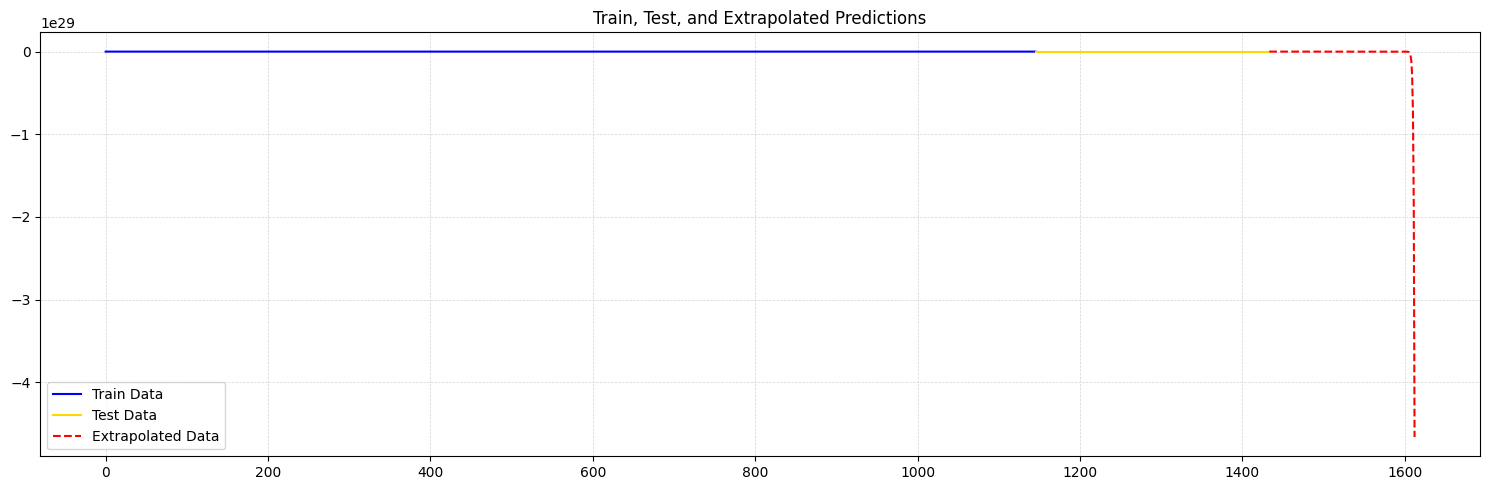

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(x_train, scaler.inverse_transform(train_scaled), label='Train Data', color='blue')
plt.plot(x_test, scaler.inverse_transform(test_scaled), label='Test Data', color='gold')
plt.plot(x_extrapolated, extrapolated_rescaled, label='Extrapolated Data', linestyle='dashed', color='red')
plt.legend(fontsize=10)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.title('Train, Test, and Extrapolated Predictions')
plt.tight_layout()
plt.show()

### Personal Analysis / Refelection

The model was trained on a simple single-feature dataset, making it easier to learn the pattern. Although the R² score on the test set was low at 0.3327, the low RMSE of 0.2478 shows the model could predict the next point quite well. The MAPE of 18.13% means the predictions were off by an average of 18.13%, which is decent but could be improved.